# Turing JL

## Turing Tutorials

# 4. Bayesian Logistic Regression

**TuringLang contributors**

**Source:** https://turing.ml/dev/tutorials/02-logistic-regression/

In this notebook we learn how to use `Turing.jl` to do implement Bayesian logistic regression.


In [5]:
using Turing
using Distributions
using DataFrames
using RDatasets
using MCMCChains
using MLDataUtils: shuffleobs, stratifiedobs, splitobs, rescale!
using StatsFuns: logistic
using Plots
using StatsPlots
using Distances
using Random

Random.seed!(0)

# Hide the progress prompt while sampling.
Turing.setprogress!(false);

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/josinai/.julia/packages/Turing/YGtAo/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /home/josinai/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


We'll use the `Default` dataset for predicting credit defaults.

In [2]:
# Import the "Default" dataset.
data = RDatasets.dataset("ISLR", "Default");
first(data, 6)

,Default,Student,Balance,Income
,Cat…,Cat…,Float64,Float64
1,No,No,729.526,44361.6
2,No,Yes,817.18,12106.1
3,No,No,1073.55,31767.1
4,No,No,529.251,35704.5
5,No,No,785.656,38463.5
6,No,Yes,919.589,7491.56


We need to do some basic cleaning of the data, in particular to convert the categorical response variable `Default` to a binary boolean variable.

In [3]:
# Convert "Default" and "Student" to numeric values.
data[!,:DefaultNum] = [r.Default == "Yes" ? 1.0 : 0.0 for r in eachrow(data)]
data[!,:StudentNum] = [r.Student == "Yes" ? 1.0 : 0.0 for r in eachrow(data)]

select!(data, Not([:Default, :Student]))
first(data, 6)

,Balance,Income,DefaultNum,StudentNum
,Float64,Float64,Float64,Float64
1,729.526,44361.6,0.0,0.0
2,817.18,12106.1,0.0,1.0
3,1073.55,31767.1,0.0,0.0
4,529.251,35704.5,0.0,0.0
5,785.656,38463.5,0.0,0.0
6,919.589,7491.56,0.0,1.0


Now split the datasets and rescale. We'll use stratification to ensure that we the default categories are balanced across both splits.

In [6]:
function split_data(df, target; at = 0.70)
    shuffled = shuffleobs(df)
    trainset, testset = stratifiedobs(row -> row[target], 
                                      shuffled, p = at)
end

features = [:StudentNum, :Balance, :Income]
numerics = [:Balance, :Income]
target = :DefaultNum

# we'll use a very small training set to show the power of Bayesian inference on small data.
trainset, testset = split_data(data, target, at = 0.05)
for feature in numerics
  μ, σ = rescale!(trainset[!, feature], obsdim=1)
  rescale!(testset[!, feature], μ, σ, obsdim=1)
end

# Convert the data into a matrix/vector
X_train = Matrix(trainset[:, features])
X_test = Matrix(testset[:, features])
y_train = trainset[:, target]
y_test = testset[:, target];

### Bayesian Logistic Regression Model

We'll assume that the probability of a default follows a Binomial distribution regressed on a linear combination of the `StudentNum` binary variable and the `Balance` and `Income` continuous variables. We'll assume that the coefficients and intercept term have a normal prior with mean zero and common standard deviation `$\sigma$`. The model which we will create takes 4 arguments:


- `X`: the feature matrix.
- `y`: the labeled response vector.
- `n`: the number of observations.
- `σ`: is the standard deviation assumed for the normal priors.


In [7]:
@model bayesian_logistic_regression(X, y, n, σ) = begin
    intercept ~ Normal(0, σ)

    student ~ Normal(0, σ)
    balance ~ Normal(0, σ)
    income  ~ Normal(0, σ)

    for i = 1:n
        v = logistic(intercept + student*X[i, 1] + balance*X[i,2] + income*X[i,3])
        y[i] ~ Bernoulli(v)
    end
end;

Now let's run a sampling process, in this case Hamiltonian Monte Carlo, to approximate (ie train) the posterior distribution:

In [9]:
# Retrieve the number of observations.
n, _ = size(X_train)

# Sample using HMC.
m = bayesian_logistic_regression(X_train, y_train, n, 1)
chain = sample(m, HMC(0.05, 10), MCMCThreads(), 1_500, 3);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/josinai/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


Now let's use the plot utility to diagnose chain converge for each variable. Notice how giving helpful names to the variables lets us easily distinguish between the posterior distributions for each variable. If we had used something like $\beta \sim MvNormal(3, \sigma)$ then we would only see $\beta[i]$ in the plot labels.

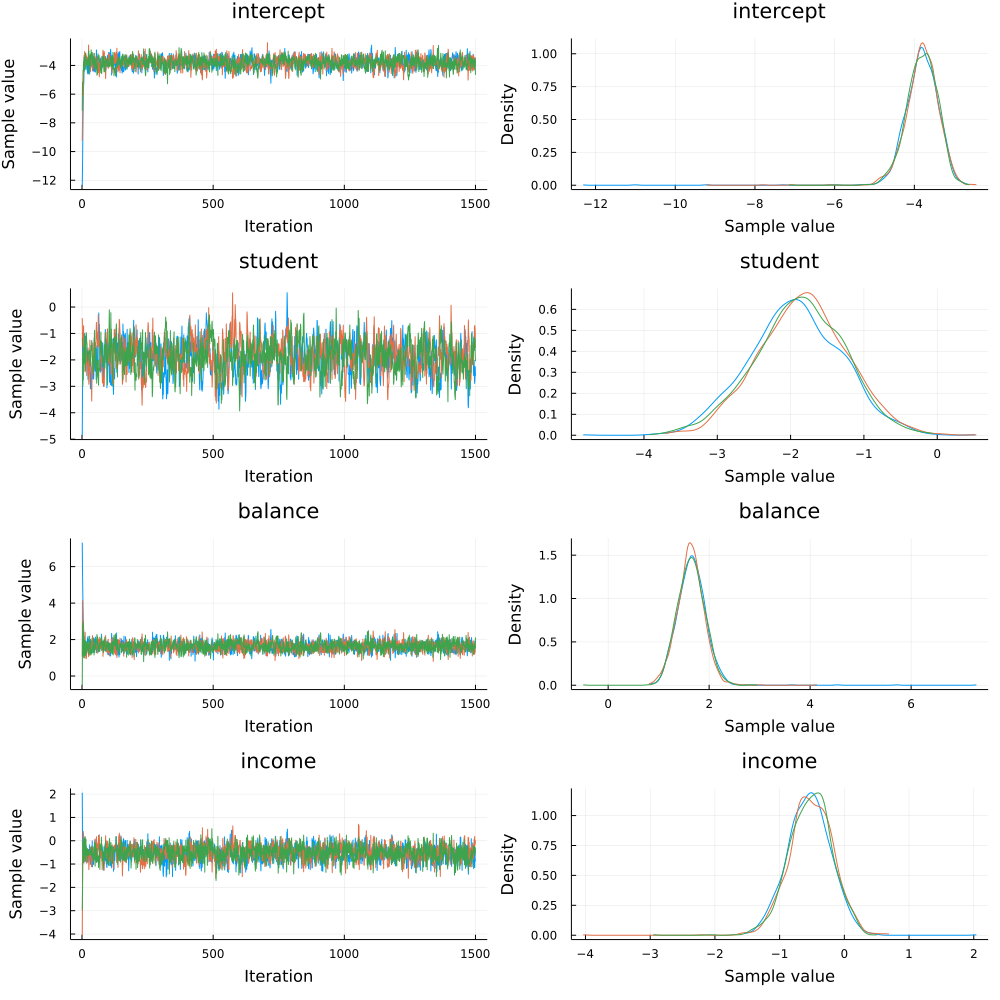

In [10]:
plot(chain)

We can see that each of the chains have tended to converge to the same approximation.

Another helpful diagnostic plot is the `corner` function which shows how the three feature variables interact:

In [11]:
# Requires StatsPlots and MCMCChains.
corner(chain, [:student, :balance, :income])

Fortunately the corner plot appears to demonstrate unimodal distributions for each of the parameters, so we can take the means of each parameter's sampled values to make predictions.

In [13]:
function predict(X::Matrix, chain, threshold)
    # Pull the means from each parameter's sampled values in the chain.
    intercept = mean(chain[:intercept])
    student = mean(chain[:student])
    balance = mean(chain[:balance])
    income = mean(chain[:income])

    # Retrieve the number of rows.
    n, _ = size(X)

    # Generate a vector to store our predictions.
    v = Vector{Float64}(undef, n)

    # Calculate the logist score for each element in the test set.
    for i in 1:n
        num = logistic(intercept .+ student * X[i,1] + balance * X[i,2] + income * X[i,3])
        if num >= threshold
            v[i] = 1
        else
            v[i] = 0
        end
    end
    return v
end

predict (generic function with 1 method)

### Test set evaluation

In [14]:
# Set the prediction threshold.
threshold = 0.07

# Make the predictions.
predictions = predict(X_test, chain, threshold)

# Calculate MSE for our test set.
loss = sum((predictions - y_test).^2) / length(y_test)

0.1171578947368421

0.1171578947368421

### Class Accuracy

Perhaps more important is to see what percentage of defaults we correctly predicted. The code below simply counts defaults and predictions and presents the results.

In [32]:
defaults = sum(y_test)
not_defaults = length(y_test) - defaults

predicted_defaults = sum(y_test .== predictions .== 1)
predicted_not_defaults = sum(y_test .== predictions .== 0)

println("Defaults: $defaults
    Predictions: $predicted_defaults
    Percentage defaults correct $(predicted_defaults/defaults)")

println("Not defaults: $not_defaults
    Predictions: $predicted_not_defaults
    Percentage non-defaults correct $(predicted_not_defaults/not_defaults)")

Defaults: 316.0
    Predictions: 265
    Percentage defaults correct 0.8386075949367089
Not defaults: 9184.0
    Predictions: 8122
    Percentage non-defaults correct 0.8843641114982579
